In [1]:
import torch

import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from plot import draw_apparatus
from image_data_helpers import get_data, get_dataset
from mpl_toolkits.axes_grid1 import ImageGrid

import time
from tqdm import tqdm

%matplotlib inline

## Epoch testing code

The number of epochs required to train autoencoder models will be verified in this notebook. This requires a set dataset with a specific excluded validation set, and a specific model. Performance will be evaluated by training the model over 100 , 1000, 10000, and 20000 epochs to determine when overfitting happens (validation score >> train score). In addition, model performance also needs to be evaluated by examining the predicted profiles. 

In [2]:
def plot_data(data):
    from plot import draw_apparatus
    fig, ax = plt.subplots(ncols=5, sharey=True)
    for i in range(5):
        ax[i].imshow(data[i, :, :], origin='lower', extent=[0, 20, 0, 70.7])
        draw_apparatus(ax[i])

    return fig

In [3]:
test = get_dataset(300, 80) 

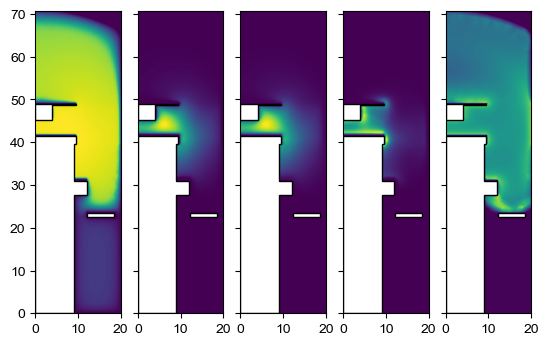

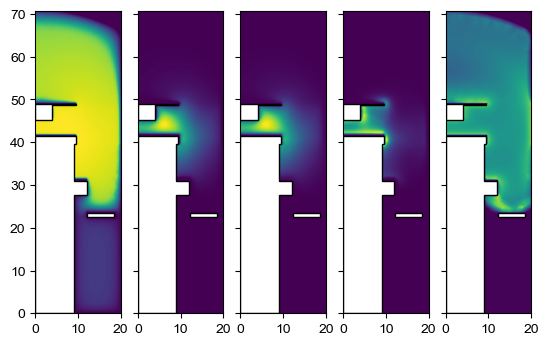

In [4]:
plot_data(test)

### To do:
* plot train and validation error (I can probably just use the one in plot.py)
* plot images

In [5]:
test.shape

(5, 707, 200)

In [6]:
def plot_crop(data, cbar=None):
    fig = plt.figure()

    grid = ImageGrid(fig, 111,  # similar to fig.add_subplot(142).
                     nrows_ncols=(1, 5), axes_pad=0.0, label_mode="L", share_all=True,
                     cbar_location="right", cbar_mode=cbar, cbar_size="5%", cbar_pad='5%')

    for i, ax in enumerate(grid):
        im = ax.imshow(data[i, :, :], origin='lower', 
                       extent=[0, 20, 35, 55], cmap='magma')
        draw_apparatus(ax)

    grid.cbar_axes[0].colorbar(im)

In [7]:
if torch.cuda.is_available(): 
    device = "cuda:0" 
elif torch.backends.mps.is_available():
    device = 'mps'
else: 
    device = "cpu" 

device

'mps'

In [8]:
# load train and validation sets
validation_pair = (400.0, 45.0)
test_pair = (300.0, 60.0)

train, test, val = get_data(test_pair, validation_pair, resolution=64, square=True)

In [9]:
train_set = torch.tensor(train, dtype=torch.float32, device=device)
test_set = torch.tensor(test, dtype=torch.float32, device=device)
val_set = torch.tensor(val, dtype=torch.float32, device=device)

In [10]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(train_set)
trainloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [11]:
# training hyperparameters
conf_dict = {'epochs':100, 'learning_rate':1e-3}

In [12]:
from autoencoder_classes import A64_6
import torch.nn as nn
import torch.optim as optim

epochs = conf_dict['epochs']
learning_rate = conf_dict['learning_rate']
model = A64_6().to(device=device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
epoch_loss = []
epoch_validation = []
loop = tqdm(range(epochs), desc='Training...', unit='epoch', colour='#7dc4e4')

train_start = time.perf_counter()
for epoch in loop:
    for i, batch_data in enumerate(trainloader):
        # get inputs
        inputs = batch_data[0]
        optimizer.zero_grad()

        # record loss
        running_loss = 0.0

        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}/{epochs}")

    with torch.no_grad():
        val_loss = criterion(model(val_set), val_set).item()

    epoch_validation.append(val_loss)
    epoch_loss.append(running_loss)

    # if (epoch+1) % epochs == 0:
    #     # save model every 10 epochs (so i dont lose all training progress in case i do something unwise)
    #     # pytorch checkpoints
    #     torch.save(model.state_dict(), out_dir/f'{name}')

train_end = time.perf_counter()
print(f'training finished in {train_end-train_start} s')

Training...:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 100/100: 100%|██████████| 100/100 [00:48<00:00,  2.08epoch/s]

training finished in 48.167083624983206 s


In [14]:
def plot_train_loss(losses, validation_losses=None, out_dir=None):  # TODO: move to plot module

    losses = np.array(losses)
    fig, ax = plt.subplots(figsize=(10,4), dpi=200)
    ax.set_yscale('log')
    ax.plot(losses, c='k', label='train')

    if validation_losses is not None:
        ax.plot(validation_losses, c='r', ls=':', label='validation')
        ax.legend()

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid()

    if out_dir is not None:
      fig.savefig(out_dir/'train_loss.png')

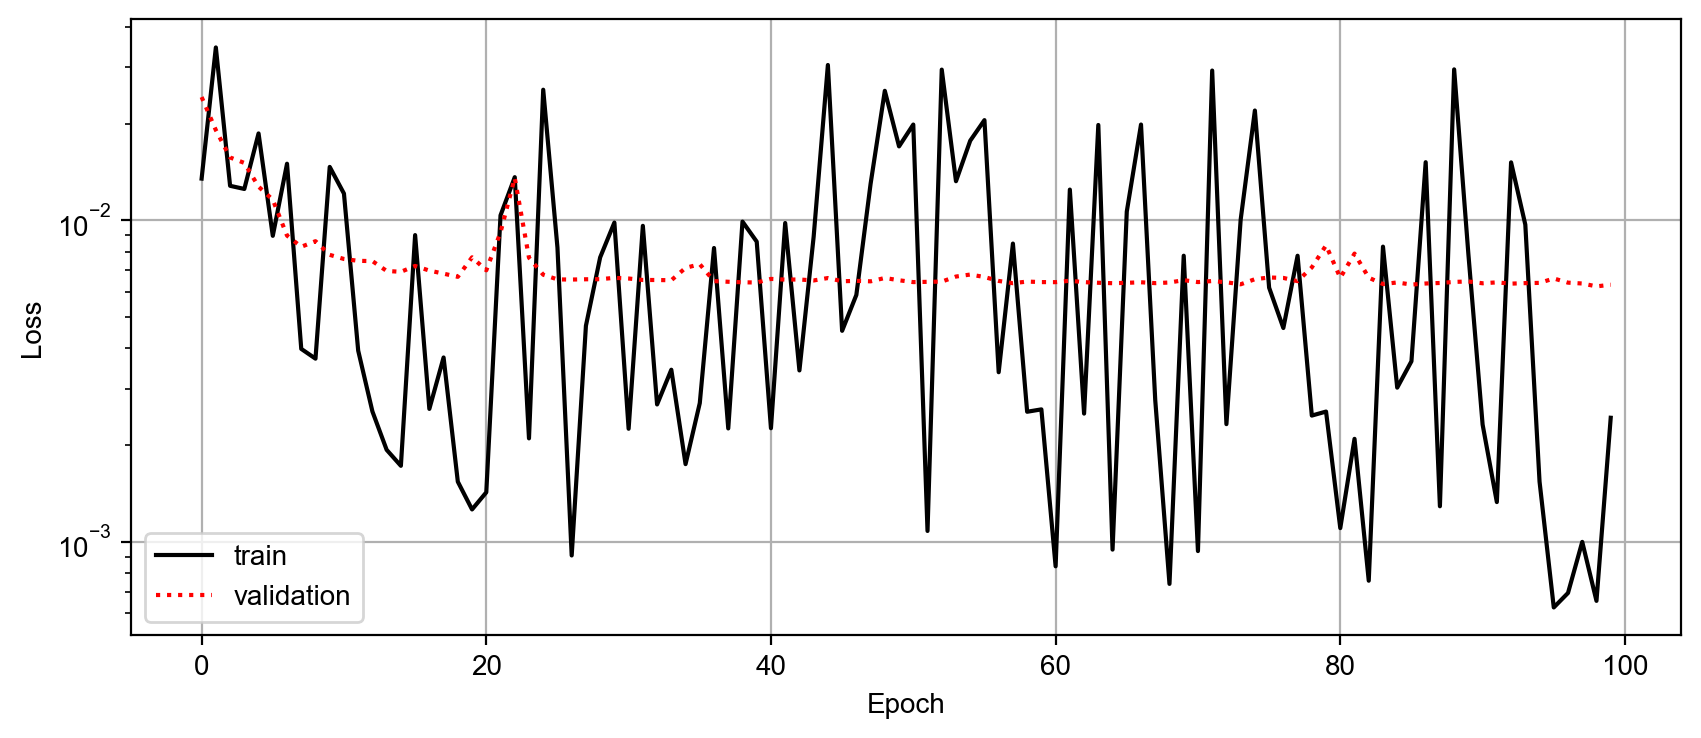

In [15]:
plot_train_loss(epoch_loss, epoch_validation)